# Qualitative Error analysis

In [1]:
import numpy as np
import sys
sys.path.append('src/')
import torch
from time import time
from torch.autograd import Variable
from data.dataset_utils import TilesClassificationDataLoader
#from model_architectures.googlenet.googtilenet import make_googtilenet
from model_architectures.googlenet.googtilenet_v3 import make_googtilenet
from utils import get_timestr
from tqdm import tqdm 

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

cuda = torch.cuda.is_available()
in_channels = 4
z_dim = 512
net = make_googtilenet(in_channels=in_channels, z_dim=z_dim)
if cuda: 
    net = net.cuda()

# Load parameters
checkpoint = torch.load("src/models/GoogTiLeNet_v3_epoch3.ckpt")
net.load_state_dict(checkpoint)
net.eval()

n_tiles = 1000
X = np.zeros((n_tiles, z_dim))
y = np.zeros(n_tiles)

dataloader = TilesClassificationDataLoader(batch_size=1, num_tiles_requested = n_tiles)

print(f'Begin at {get_timestr()}................')
for i, sample in enumerate(tqdm(dataloader)):
    tile = sample['tile']
    tile = torch.squeeze(tile, dim=0)
    label = sample['label']
    y[i] = label
    tile = Variable(tile)
    if cuda: 
        tile = tile.cuda()
    z = net.forward(tile)
    if cuda: z = z.cpu()
    z = z.data.numpy()

    z.squeeze(0)
    X[i, :] = z

print(f'{get_timestr()} | finished embedding')
y = LabelEncoder().fit_transform(y)
# print(set(y))
print(f'{get_timestr()} | finished encoding labels')

n_trials = 1
accs = np.zeros((n_trials,))
for i in range(n_trials):
    # Splitting data and training RF classifer
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
    rf = RandomForestClassifier()
    rf.fit(X_tr, y_tr)
    accs[i] = rf.score(X_te, y_te)
    print(f'Trial {i} has accuracy {accs[i]}')
print('Mean accuracy: {:0.4f}'.format(accs.mean()))
print('Standard deviation: {:0.4f}'.format(accs.std()))

print(f'End at {get_timestr()}................')

Begin at 06:33 PM, June 07................


100%|██████████| 1000/1000 [00:15<00:00, 66.51it/s]


06:33 PM, June 07 | finished embedding
06:33 PM, June 07 | finished encoding labels
Trial 0 has accuracy 0.485
Mean accuracy: 0.4850
Standard deviation: 0.0000
End at 06:33 PM, June 07................


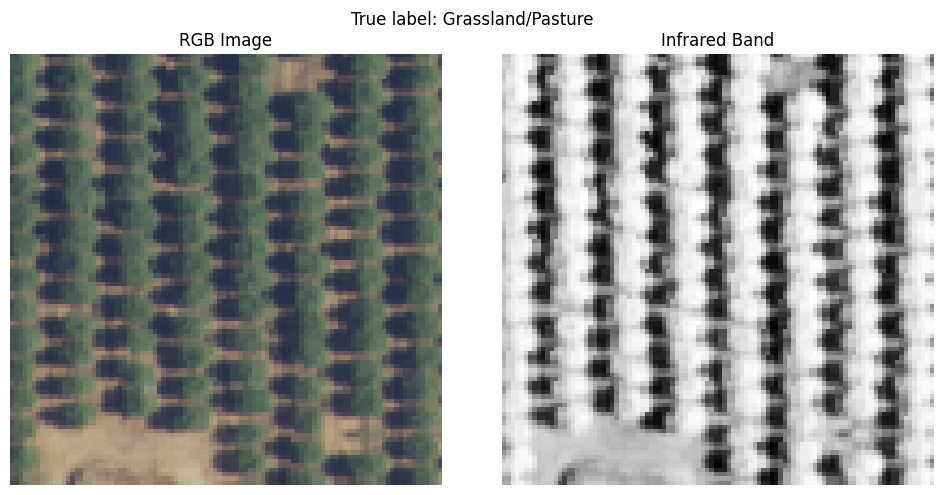

In [2]:
# Creation of labels.csv
# data_dir = '/home/ubuntu/cs231n_project/cs231n_project/land_cover_representation/'
# metadata = pd.read_csv(os.path.join(data_dir,'metadata.csv'))
# labels = metadata[['y', 'land_cover']].drop_duplicates().sort_values('y')
# labels.to_csv('src/data/labels.csv', index=False)

z = dataloader.dataset[0]

from utils import viz
viz(z)


# Fix nan losses

In [3]:
from torch.utils.data import Dataset, DataLoader
import sys
import os
import torch
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
import time
from tqdm import tqdm 

sys.path.append('src/')
from data.dataset_utils import TripletDataLoader
#from model_architectures.googlenet.googtilenet import make_googtilenet
from model_architectures.googlenet.googtilenet_v3 import make_googtilenet
from training import train_triplet_epoch

img_type = 'naip'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

cuda = torch.cuda.is_available()
in_channels = 4
z_dim = 512

def prep_triplets(triplets, cuda):
    """
    Takes a batch of triplets and converts them into Pytorch variables 
    and puts them on GPU if available.
    """
    a, n, d = (Variable(triplets['anchor']), Variable(triplets['neighbor']), Variable(triplets['distant']))
    if cuda:
    	a, n, d = (a.cuda(), n.cuda(), d.cuda())
    return (a, n, d)


In [17]:
net = make_googtilenet(in_channels=in_channels, z_dim=z_dim)
if cuda: net.cuda()
net.train()

# Load parameters
epoch_start = 3
model_fn = f'src/models/GoogTiLeNet_v3_epoch{epoch_start}.ckpt'
checkpoint = torch.load(model_fn)
net.load_state_dict(checkpoint)
net.train()

print('GoogTiLeNet set up complete.')

lr = 1e-3
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=0.01)
scheduler = None
# scheduler = MultiStepLR(optimizer, 
#                         milestones=[3, 4], # List of epoch indices
#                         gamma =0.1)

print('Optimizer set up complete.')

dataloader = TripletDataLoader(img_type, batch_size=64)

print('Dataset set up.')

margin = 10
l2 = 0.01
max_grad_norm = 1.0
print_every=1

net.train()
sum_loss, sum_l_n, sum_l_d, sum_l_nd = (0, 0, 0, 0)
n_train, n_batches = len(dataloader.dataset), len(dataloader)
print_sum_loss = 0
verbose=False
for idx, triplets in enumerate(tqdm(dataloader, desc="training loop within epoch")):
    p, n, d = prep_triplets(triplets, cuda)
    optimizer.zero_grad()
    #verbose = idx==23
    loss, l_n, l_d, l_nd = net.loss(p, n, d, margin=margin, l2=l2, verbose=verbose)
    
    if torch.isnan(loss) or torch.isinf(loss):
            for param_group in optimizer.param_groups:
                learning_rate = param_group['lr']
                print("Learning rate:", learning_rate)
            print(f"Stopping at epoch {epoch_start+1} id {idx} because of nan loss")
            raise 
    loss.backward()

    # Track max and min gradients with layer names
    # max_grad = (-float('inf'), None, None)  # (grad_value, layer_name, parameter_name)
    # min_grad = (float('inf'), None, None)  # (grad_value, layer_name, parameter_name)
    # for name, param in net.named_parameters():
    #     if 'weight' in name and 'Aux' not in name:
    #         grad = param.grad
    #         max_grad = max(max_grad, (grad.abs().max().item(), name, param))
    #         min_grad = min(min_grad, (grad.abs().min().item(), name, param))
    
    # print("Max gradient layer:", max_grad[1])
    # #print("Parameter:", max_grad[2])
    # print("Max gradient value:", max_grad[0])
    
    # print("Min gradient layer:", min_grad[1])
    # #print("Parameter:", min_grad[2])
    # print("Min gradient value:", min_grad[0])

    if max_grad_norm:
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_grad_norm)
    optimizer.step()
    if scheduler:
        scheduler.step(loss)

    sum_loss += loss.data
    # sum_l_n += l_n.data
    # sum_l_d += l_d.data
    # sum_l_nd += l_nd.data
    if (idx + 1) * dataloader.batch_size % print_every == 0:
            print_avg_loss = (sum_loss - print_sum_loss) / (
                print_every / dataloader.batch_size)
            print('[{}/{} ], avg loss: {:0.4f}'.format(
                    (idx + 1) * dataloader.batch_size, n_train,
                loss.data))
            print_sum_loss = sum_loss
# avg_loss = sum_loss / n_batches
# avg_l_n = sum_l_n / n_batches
# avg_l_d = sum_l_d / n_batches
# avg_l_nd = sum_l_nd / n_batches
# print('Finished epoch {}: {:0.3f}s'.format(epoch, time()-t0))
# print('  Average loss: {:0.4f}'.format(avg_loss))
# print('  Average l_n: {:0.4f}'.format(avg_l_n))
# print('  Average l_d: {:0.4f}'.format(avg_l_d))
# print('  Average l_nd: {:0.4f}\n'.format(avg_l_nd))
# return (avg_loss, avg_l_n, avg_l_d, avg_l_nd)

GoogTiLeNet set up complete.
Optimizer set up complete.
73894
Dataset set up.


training loop within epoch:   0%|          | 1/1155 [00:00<13:07,  1.46it/s]

[64/73894 ], avg loss: 24.6947


training loop within epoch:   0%|          | 2/1155 [00:00<08:42,  2.21it/s]

[128/73894 ], avg loss: 16.1989


training loop within epoch:   0%|          | 3/1155 [00:01<07:18,  2.63it/s]

[192/73894 ], avg loss: 27.0101


training loop within epoch:   0%|          | 4/1155 [00:01<06:40,  2.88it/s]

[256/73894 ], avg loss: 19.7152


training loop within epoch:   0%|          | 5/1155 [00:01<06:20,  3.02it/s]

[320/73894 ], avg loss: 16.6981


training loop within epoch:   1%|          | 6/1155 [00:02<06:06,  3.14it/s]

[384/73894 ], avg loss: 14.7048


training loop within epoch:   1%|          | 7/1155 [00:02<05:58,  3.21it/s]

[448/73894 ], avg loss: 12.7984


training loop within epoch:   1%|          | 8/1155 [00:02<05:52,  3.26it/s]

[512/73894 ], avg loss: 11.3924


training loop within epoch:   1%|          | 9/1155 [00:03<05:48,  3.29it/s]

[576/73894 ], avg loss: 10.6014


training loop within epoch:   1%|          | 10/1155 [00:03<05:43,  3.33it/s]

[640/73894 ], avg loss: 10.3410


training loop within epoch:   1%|          | 11/1155 [00:03<05:40,  3.36it/s]

[704/73894 ], avg loss: 10.2463


training loop within epoch:   1%|          | 12/1155 [00:03<05:38,  3.38it/s]

[768/73894 ], avg loss: 10.2101


training loop within epoch:   1%|          | 13/1155 [00:04<05:37,  3.39it/s]

[832/73894 ], avg loss: 10.1499


training loop within epoch:   1%|          | 14/1155 [00:04<05:34,  3.41it/s]

[896/73894 ], avg loss: 10.1667
Learning rate: 0.01
Stopping at epoch 4 id 14 because of nan loss


training loop within epoch:   1%|          | 14/1155 [00:04<06:25,  2.96it/s]


RuntimeError: No active exception to reraise